#Final Project

##PART 1

In [324]:
import pandas as pd
import numpy as np
dfPath = "input files/messages.csv"

df = pd.read_csv(dfPath)
df = df.reset_index(drop=True)
df['sender'] = df['sender'].astype(str)
df['message'] = df['message'].astype(str)

###Preprocessing:
Import our 5 whatsapp personal messages, and translate them from hebrew to english messages.
Collapse last 400 messages from each file to single file calls 'messages'.
Before the translation we delete all the characters that not match to the above:
- english alphabet
- hebrew alphabet
- spaces


In [246]:
'''
messageLimit = 400
files = ["PersonalMessages/OHAD.csv" , "PersonalMessages/ORI.csv"
         ,"PersonalMessages/LILACH.csv"
         ,"PersonalMessages/KOREN.csv"
         ,"PersonalMessages/NAOR.csv"]
'''

'\nmessageLimit = 400\nfiles = ["PersonalMessages/OHAD.csv" , "PersonalMessages/ORI.csv"\n         ,"PersonalMessages/LILACH.csv"\n         ,"PersonalMessages/KOREN.csv"\n         ,"PersonalMessages/NAOR.csv"]\n'

In [247]:
'''
from googletrans import Translator
import re
translator = Translator()
for index, file in enumerate(files):
    df = pd.read_csv(file).tail(messageLimit)
    x = np.array(df['message']).tolist()
    x = list(map(lambda s : re.sub("[^\sa-zA-Zא-ת]","",s) , x))
    df['message'] = list(map(lambda t : t.text , translator.translate(x , src='hebrew' , dest='english')))
    header = index == 0
    df.to_csv(dfPath , mode = 'a' , header = header)
'''


'\nfrom googletrans import Translator\nimport re\ntranslator = Translator()\nfor index, file in enumerate(files):\n    df = pd.read_csv(file).tail(messageLimit)\n    x = np.array(df[\'message\']).tolist()\n    x = list(map(lambda s : re.sub("[^\\sa-zA-Zא-ת]","",s) , x))\n    df[\'message\'] = list(map(lambda t : t.text , translator.translate(x , src=\'hebrew\' , dest=\'english\')))\n    header = index == 0\n    df.to_csv(dfPath , mode = \'a\' , header = header)\n'

We create a function for stemming and clean stop words

In [325]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import nltk

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

def stem_sentence(sentence):
    return " ".join([lancaster.stem(w) for w in sentence.split(" ")])

def messageToWords(message):
    letters_only = re.sub("[^a-zA-Z]", " ", message) 
    # split into individual words
    
    words = letters_only.split()                             
    #
    # In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    #  Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [326]:
# Get the number of messages based on the dataframe column size
numMessages = df["message"].size
# Initialize an empty list to hold the clean messages
clean_messages = []
# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, numMessages ):
    # Call our function for each one, and add the result to the list of
    # clean messages
    clean_messages.append( stem_sentence(messageToWords( df["message"][i] ) ))
clean_messages = [mess for mess in clean_messages if mess != '']


##PART 2


Create the bag-of-words function, that use the CountVectorizer function, We choose max_features to 1000 for the high frequency words, the number is not to big because we dont want to detract the results. We set the stopwords parameter to english to support english stopwords.

In [327]:
from sklearn.feature_extraction.text import CountVectorizer
def create_bag_of_words(messages):
    vectorizer = CountVectorizer(analyzer = "word",   
                                 tokenizer = None,    
                                 preprocessor = None, 
                                 stop_words = stopwords.words("english"),   
                                 max_features = 1000) 
    
    # fit_transform() Convert a collection of text documents to a matrix of token counts.
    # This implementation produces a sparse representation.
    # The input to fit_transform should be a list of strings.
    train_data_features = vectorizer.fit_transform(messages)
    
    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    return train_data_features.toarray()

train_data_features = create_bag_of_words(clean_messages)

We divide the input into test & train sets

In [328]:
#split to train & test
msk = np.random.rand(len(clean_messages)) < 0.8
train_x = train_data_features[msk]
test_x = train_data_features[~msk]
train_y = df.loc[msk,"sender"]
test_y = df.loc[~msk,"sender"]


Now we will check some classification algorithms that we learn, and compare them.

###Gradient boosting classifier
Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [329]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_alg = GradientBoostingClassifier(random_state=10) 

gbc = gbc_alg.fit(train_x, train_y)

gbc_score = gbc.score(test_x, test_y)

gbc_score

0.31909547738693467

###Linear Discriminant Analysis
Linear discriminant analysis (LDA) is a generalization of Fisher's linear discriminant, a method used in statistics, pattern recognition and machine learning to find a linear combination of features that characterizes or separates two or more classes of objects or events. The resulting combination may be used as a linear classifier, or, more commonly, for dimensionality reduction before later classification.

In [330]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.fit(train_x, train_y)

lda_score = lda.score(test_x,test_y)

lda_score

C:\Users\user\PycharmProjects\project\venv\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.



0.3492462311557789

Compare the various algorithms with diagram

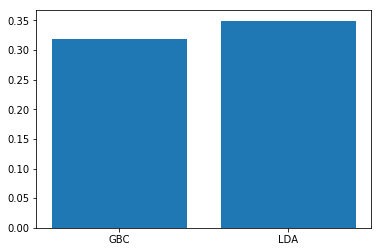

In [331]:
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline
dictionary = plt.figure()

D = {u'GBC':gbc_score,  u'LDA':lda_score}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()

We can see the LDA algorithm has the highest results.

##PART 3

In [332]:
from keras import backend as K
K.set_image_dim_ordering('th')

We take all the messages of each person and make them a single sequnce that every message seprated by delimiter 'DELIMITER', the purpose of the delimiter is to know when stop create new message

In [333]:
MESSAGE_DELIMITER = ' DELIMITER '
ohadName = 'ohad'
lilachName = 'lilach'
naorName = 'naor'
korenName = 'koren'
oriName = 'ori'
ohad_messages = df.loc[df['sender'] == ohadName]['message']
lilach_messages = df.loc[df['sender'] == lilachName]['message']
naor_messages = df.loc[df['sender'] == naorName]['message']
koren_messages = df.loc[df['sender'] == korenName]['message']
ori_messages = df.loc[df['sender'] == oriName]['message']

def get_messages_joined(messages):
    return MESSAGE_DELIMITER.join(messages)
    
ohad_messages = get_messages_joined(ohad_messages)
lilach_messages = get_messages_joined(lilach_messages)
naor_messages = get_messages_joined(naor_messages)
koren_messages = get_messages_joined(koren_messages)
ori_messages = get_messages_joined(ori_messages)

Most words in our messages will only appear one or two times. so we remove these infrequent words. Having a huge vocabulary will make our model slow to train, and because we don’t have a lot of contextual examples for such words we wouldn’t be able to learn how to use them correctly anyway.To really understand how to appropriately use a word you need to have seen it in different contexts. In our code we limit our vocabulary to the vocabulary_size most common words (which was set to 600, mainly for memory limitations).

- We replace all words not included in our vocabulary by UNKNOWN_TOKEN.
- We also want to learn which words tend start and end a sentence. To do this we prepend a special SENTENCE_START token, and append a special SENTENCE_END token to each sentence.

In [334]:
vocabulary_size = 600
unknown_token = "UNKNOWNTOKEN"
sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"
line_break= "NEWLINE"
separator= "SEPARATOR"

Create a function that convert these special characters into the mentioned tokens:

In [335]:

def replace_specific_symbols_and_clean(message):
    message = message.replace('...', '.')
    message = message.replace('....', '.')
    message = message.replace('\n',' '+ line_break + ' ')
    message = message.replace('--',' '+ separator + ' ')
    message = message.replace('.',' '+sentence_end_token +' '+ sentence_start_token+' ' )
    return messageToWords(message)

Convert these special characters for each person messages

In [336]:
ohad_messages_cleaned = replace_specific_symbols_and_clean(ohad_messages)
lilach_messages_cleaned = replace_specific_symbols_and_clean(lilach_messages)
naor_messages_cleaned = replace_specific_symbols_and_clean(naor_messages)
koren_messages_cleaned = replace_specific_symbols_and_clean(koren_messages)
ori_messages_cleaned = replace_specific_symbols_and_clean(ori_messages)


We split the messages to list of words in the original order.
The main paramterts are 'lower' (lower case) that not neccesary to us so we choose false, and 'split' is space between words

In [337]:
from keras.preprocessing.text import text_to_word_sequence
ohad_messages_splitted = text_to_word_sequence(ohad_messages_cleaned, lower=False, split=" ")
lilach_messages_splitted = text_to_word_sequence(lilach_messages_cleaned, lower=False, split=" ")
naor_messages_splitted = text_to_word_sequence(naor_messages_cleaned, lower=False, split=" ")
koren_messages_splitted = text_to_word_sequence(koren_messages_cleaned, lower=False, split=" ")
ori_messages_splitted = text_to_word_sequence(ori_messages_cleaned, lower=False, split=" ")


The input to our Recurrent Neural Networks are vectors, not strings. So we create a mapping between words and indices.

Tokenizer is a class for vectorizing texts, or/and turning texts into sequences.
 It considers the vocabulary size (nb_words) for indexing most frequent words, otherwise using the unknown-token index.

In [338]:
from keras.preprocessing.text import Tokenizer
ohad_tokenizer = Tokenizer(num_words=150,char_level=False)
ohad_tokenizer.fit_on_texts(ohad_messages_splitted)

lilach_tokenizer = Tokenizer(num_words=150,char_level=False)
lilach_tokenizer.fit_on_texts(lilach_messages_splitted)

naor_tokenizer = Tokenizer(num_words=150,char_level=False)
naor_tokenizer.fit_on_texts(naor_messages_splitted)

koren_tokenizer = Tokenizer(num_words=150,char_level=False)
koren_tokenizer.fit_on_texts(koren_messages_splitted)

ori_tokenizer = Tokenizer(num_words=150,char_level=False)
ori_tokenizer.fit_on_texts(ori_messages_splitted)

We represent each word as a one-hot vector of size vocabulary_size. So, each word will become a vector, and the input will be a matrix, with each row representing a word.

texts_to_matrix performs this conversion for us when setting the mode parameter to 'binary'.

In [339]:
ohad_text_mtx = ohad_tokenizer.texts_to_matrix(ohad_messages_splitted, mode='binary')

lilach_text_mtx = lilach_tokenizer.texts_to_matrix(lilach_messages_splitted, mode='binary')

naor_text_mtx = naor_tokenizer.texts_to_matrix(naor_messages_splitted, mode='binary')

koren_text_mtx = koren_tokenizer.texts_to_matrix(koren_messages_splitted, mode='binary')

ori_text_mtx = ori_tokenizer.texts_to_matrix(ori_messages_splitted, mode='binary')

our goal is to predict the next word, but we learn the model by the three last words

In [340]:
ohad_input = ohad_text_mtx[:-3]
ohad_output = ohad_text_mtx[3:]

lilach_input = lilach_text_mtx[:-3]
lilach_output = lilach_text_mtx[3:]

naor_input = naor_text_mtx[:-3]
naor_output = naor_text_mtx[3:]

koren_input = koren_text_mtx[:-3]
koren_output = koren_text_mtx[3:]

ori_input = ori_text_mtx[:-3]
ori_output = ori_text_mtx[3:]

###Recurrent Neural Network
We use simple recurrent neural network for adding a full connected Recurrent neural network.
We create vocabulary for each person and removes duplicates.

In [341]:
import pandas as pd
import numpy as np

ohad_vocab = pd.DataFrame({'word':ohad_messages_splitted,'code':np.argmax(ohad_text_mtx,axis=1)})
ohad_vocab = ohad_vocab.drop_duplicates()

lilach_vocab = pd.DataFrame({'word':lilach_messages_splitted,'code':np.argmax(lilach_text_mtx,axis=1)})
lilach_vocab = lilach_vocab.drop_duplicates()

naor_vocab = pd.DataFrame({'word':naor_messages_splitted,'code':np.argmax(naor_text_mtx,axis=1)})
naor_vocab = naor_vocab.drop_duplicates()

koren_vocab = pd.DataFrame({'word':koren_messages_splitted,'code':np.argmax(koren_text_mtx,axis=1)})
koren_vocab = koren_vocab.drop_duplicates()

ori_vocab = pd.DataFrame({'word':ori_messages_splitted,'code':np.argmax(ori_text_mtx,axis=1)})
ori_vocab = ori_vocab.drop_duplicates()

Importing keras libraries.

In [342]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.embeddings import Embedding

Create a sequential model for each person in order to create new messages

In [343]:
ohad_model = Sequential()

lilach_model = Sequential()

naor_model = Sequential()

koren_model = Sequential()

ori_model = Sequential()

First we adding embedding layer.
- we set the input to each person messages matrix
- we set the dimension to the number of rows in the matrix.

In [344]:
ohad_model.add(Embedding(input_dim=ohad_input.shape[1],output_dim= 42, input_length=ohad_input.shape[1]))

lilach_model.add(Embedding(input_dim=lilach_input.shape[1],output_dim= 42, input_length=lilach_input.shape[1]))

naor_model.add(Embedding(input_dim=naor_input.shape[1],output_dim= 42, input_length=naor_input.shape[1]))

koren_model.add(Embedding(input_dim=koren_input.shape[1],output_dim= 42, input_length=koren_input.shape[1]))

ori_model.add(Embedding(input_dim=ori_input.shape[1],output_dim= 42, input_length=ori_input.shape[1]))

For each person, we connect the dense output layer , by adding RNN layer with 256 hidden nodes and then passing it to the output layer.

In [345]:
from keras.layers.recurrent import SimpleRNN
n_hidden = 256

ohad_model.add(SimpleRNN(n_hidden , activation='relu' ,  recurrent_initializer = 'identity'))
ohad_model.add(Dense(ohad_output.shape[1], activation='sigmoid'))

lilach_model.add(SimpleRNN(n_hidden , activation='relu' ,  recurrent_initializer = 'identity'))
lilach_model.add(Dense(lilach_output.shape[1], activation='sigmoid'))

naor_model.add(SimpleRNN(n_hidden , activation='relu' ,  recurrent_initializer = 'identity'))
naor_model.add(Dense(naor_output.shape[1], activation='sigmoid'))

koren_model.add(SimpleRNN(n_hidden , activation='relu' ,  recurrent_initializer = 'identity'))
koren_model.add(Dense(koren_output.shape[1], activation='sigmoid'))

ori_model.add(SimpleRNN(n_hidden , activation='relu' ,  recurrent_initializer = 'identity'))
ori_model.add(Dense(ori_output.shape[1], activation='sigmoid'))

We plot a summay for each person , to learn things aboud each person model

In [346]:
ohad_model.summary(line_length=100)

lilach_model.summary(line_length=100)

naor_model.summary(line_length=100)

koren_model.summary(line_length=100)

ori_model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
embedding_46 (Embedding)                     (None, 150, 42)                         6300           
____________________________________________________________________________________________________
simple_rnn_32 (SimpleRNN)                    (None, 256)                             76544          
____________________________________________________________________________________________________
dense_36 (Dense)                             (None, 150)                             38550          
Total params: 121,394
Trainable params: 121,394
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)       

Compile the person models from training, and we declare the loss function and the optimizer.
Because this is a multi-class classification problem, we can use the log loss function (called “categorical_crossentropy” in Keras), and optimize the network using the rmsprop optimization optimizer, which is is usually a good choice for recurrent neural networks.

In [347]:
ohad_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

lilach_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

naor_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

koren_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

ori_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

To fit the model, all we have to do is declare the batch size and number of epochs to train for, then pass in our training data.

We choose 30 iterations in each model to avoid overfitting and time.

In [348]:
ohad_model.fit(ohad_input, y=ohad_output, batch_size=200, epochs=30, verbose=1, validation_split=0.2)

lilach_model.fit(lilach_input, y=lilach_output, batch_size=200, epochs=30, verbose=1, validation_split=0.2)

naor_model.fit(naor_input, y=naor_output, batch_size=200, epochs=30, verbose=1, validation_split=0.2)

koren_model.fit(koren_input, y=koren_output, batch_size=200, epochs=30, verbose=1, validation_split=0.2)

ori_model.fit(ori_input, y=ori_output, batch_size=200, epochs=30, verbose=1, validation_split=0.2)

Train on 1100 samples, validate on 276 samples
Epoch 1/30


 200/1100 [====>.........................] - ETA: 25s - loss: 3.9203 - acc: 0.0050

 400/1100 [=========>....................] - ETA: 11s - loss: 4.9626 - acc: 0.1400

 600/1100 [===============>..............] - ETA: 6s - loss: 5.2442 - acc: 0.1817 

 800/1100 [====================>.........] - ETA: 3s - loss: 5.3135 - acc: 0.2125

1000/1100 [==========================>...] - ETA: 0s - loss: 5.3925 - acc: 0.2220

1100/1100 [==============================] - 10s 9ms/step - loss: 5.3698 - acc: 0.2300 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 2/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.2797 - acc: 0.3200

 400/1100 [=========>....................] - ETA: 3s - loss: 5.6046 - acc: 0.2850

 600/1100 [===============>..............] - ETA: 2s - loss: 5.6792 - acc: 0.2767

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6111 - acc: 0.2762

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5713 - acc: 0.2700

1100/1100 [==============================] - 5s 5ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 3/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.3447 - acc: 0.2900

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7268 - acc: 0.2700

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5604 - acc: 0.2717

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5825 - acc: 0.2687

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5063 - acc: 0.2770

1100/1100 [==============================] - 5s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 4/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.3603 - acc: 0.3150

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7645 - acc: 0.2825

 600/1100 [===============>..............] - ETA: 1s - loss: 5.8126 - acc: 0.2733

 800/1100 [====================>.........] - ETA: 1s - loss: 5.7008 - acc: 0.2762

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6072 - acc: 0.2700

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 5/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.3654 - acc: 0.2850

 400/1100 [=========>....................] - ETA: 2s - loss: 5.3733 - acc: 0.2975

 600/1100 [===============>..............] - ETA: 1s - loss: 5.3932 - acc: 0.2783

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5481 - acc: 0.2662

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5797 - acc: 0.2680

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 6/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.2276 - acc: 0.2750

 400/1100 [=========>....................] - ETA: 2s - loss: 5.5916 - acc: 0.2450

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5847 - acc: 0.2467

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6007 - acc: 0.2500

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5843 - acc: 0.2640

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 7/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.9062 - acc: 0.2700

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7099 - acc: 0.2525

 600/1100 [===============>..............] - ETA: 1s - loss: 5.7155 - acc: 0.2583

 800/1100 [====================>.........] - ETA: 1s - loss: 5.7229 - acc: 0.2638

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5719 - acc: 0.2670

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 8/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.8906 - acc: 0.2450

 400/1100 [=========>....................] - ETA: 2s - loss: 5.6904 - acc: 0.2500

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6167 - acc: 0.2533

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6482 - acc: 0.2637

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5750 - acc: 0.2720

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 9/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.1288 - acc: 0.2700

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7164 - acc: 0.2725

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6662 - acc: 0.2750

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5754 - acc: 0.2813

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6031 - acc: 0.2710

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 10/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.4876 - acc: 0.2700

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4668 - acc: 0.2750

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4252 - acc: 0.2850

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6215 - acc: 0.2738

1000/1100 [==========================>...] - ETA: 0s - loss: 5.4975 - acc: 0.2820

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 11/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.6540 - acc: 0.2300

 400/1100 [=========>....................] - ETA: 2s - loss: 5.3394 - acc: 0.2625

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4218 - acc: 0.2667

 800/1100 [====================>.........] - ETA: 1s - loss: 5.4883 - acc: 0.2662

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5355 - acc: 0.2700

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 12/30


 200/1100 [====>.........................] - ETA: 3s - loss: 6.1272 - acc: 0.2600

 400/1100 [=========>....................] - ETA: 2s - loss: 5.5773 - acc: 0.2700

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5743 - acc: 0.2683

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6982 - acc: 0.2625

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5838 - acc: 0.2670

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 13/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.7112 - acc: 0.2450

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4863 - acc: 0.2775

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5050 - acc: 0.2850

 800/1100 [====================>.........] - ETA: 1s - loss: 5.4662 - acc: 0.2788

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5110 - acc: 0.2730

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 14/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.3706 - acc: 0.2550

 400/1100 [=========>....................] - ETA: 2s - loss: 5.5864 - acc: 0.2750

 600/1100 [===============>..............] - ETA: 1s - loss: 5.7155 - acc: 0.2583

 800/1100 [====================>.........] - ETA: 1s - loss: 5.6358 - acc: 0.2775

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5750 - acc: 0.2720

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 15/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.2225 - acc: 0.3050

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4057 - acc: 0.2825

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4408 - acc: 0.2717

 800/1100 [====================>.........] - ETA: 1s - loss: 5.3459 - acc: 0.2825

1000/1100 [==========================>...] - ETA: 0s - loss: 5.4544 - acc: 0.2780

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 16/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.4070 - acc: 0.2750

 400/1100 [=========>....................] - ETA: 2s - loss: 5.2056 - acc: 0.2875

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6349 - acc: 0.2633

 800/1100 [====================>.........] - ETA: 1s - loss: 5.7281 - acc: 0.2625

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5911 - acc: 0.2710

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 17/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.5448 - acc: 0.2850

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7645 - acc: 0.2825

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6531 - acc: 0.2733

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5747 - acc: 0.2850

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6025 - acc: 0.2740

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 18/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.5292 - acc: 0.2600

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4551 - acc: 0.2850

 600/1100 [===============>..............] - ETA: 1s - loss: 5.3239 - acc: 0.2950

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5955 - acc: 0.2800

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5864 - acc: 0.2750

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 19/30


 200/1100 [====>.........................] - ETA: 3s - loss: 5.5266 - acc: 0.2750

 400/1100 [=========>....................] - ETA: 2s - loss: 5.6982 - acc: 0.2625

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5067 - acc: 0.2750

 800/1100 [====================>.........] - ETA: 1s - loss: 5.5903 - acc: 0.2813

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5625 - acc: 0.2750

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 20/30


 200/1100 [====>.........................] - ETA: 3s - loss: 6.1636 - acc: 0.2800

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4044 - acc: 0.2900

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4902 - acc: 0.2933

 800/1100 [====================>.........] - ETA: 1s - loss: 5.4246 - acc: 0.2888

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5214 - acc: 0.2820

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 21/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.2641 - acc: 0.2950

 400/1100 [=========>....................] - ETA: 2s - loss: 5.5474 - acc: 0.2700

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6419 - acc: 0.2617

 800/1100 [====================>.........] - ETA: 0s - loss: 5.7391 - acc: 0.2562

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6519 - acc: 0.2650

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 22/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.2641 - acc: 0.2950

 400/1100 [=========>....................] - ETA: 2s - loss: 5.3264 - acc: 0.2800

 600/1100 [===============>..............] - ETA: 1s - loss: 5.3403 - acc: 0.2767

 800/1100 [====================>.........] - ETA: 0s - loss: 5.5214 - acc: 0.2762

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5583 - acc: 0.2760

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 23/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.9868 - acc: 0.2650

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7372 - acc: 0.2675

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4790 - acc: 0.2817

 800/1100 [====================>.........] - ETA: 0s - loss: 5.4421 - acc: 0.2737

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5797 - acc: 0.2680

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 24/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.4044 - acc: 0.2900

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4252 - acc: 0.2850

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6263 - acc: 0.2750

 800/1100 [====================>.........] - ETA: 0s - loss: 5.6475 - acc: 0.2675

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6878 - acc: 0.2650

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 25/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.8412 - acc: 0.3000

 400/1100 [=========>....................] - ETA: 2s - loss: 5.7359 - acc: 0.2750

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5596 - acc: 0.2767

 800/1100 [====================>.........] - ETA: 0s - loss: 5.5780 - acc: 0.2663

1000/1100 [==========================>...] - ETA: 0s - loss: 5.4985 - acc: 0.2760

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 26/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.6228 - acc: 0.2950

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4954 - acc: 0.2825

 600/1100 [===============>..............] - ETA: 1s - loss: 5.6263 - acc: 0.2750

 800/1100 [====================>.........] - ETA: 0s - loss: 5.6365 - acc: 0.2737

1000/1100 [==========================>...] - ETA: 0s - loss: 5.6270 - acc: 0.2710

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 27/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.6670 - acc: 0.2700

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4850 - acc: 0.2850

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5336 - acc: 0.2733

 800/1100 [====================>.........] - ETA: 0s - loss: 5.5923 - acc: 0.2700

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5552 - acc: 0.2710

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 28/30


 200/1100 [====>.........................] - ETA: 2s - loss: 4.9079 - acc: 0.2800

 400/1100 [=========>....................] - ETA: 2s - loss: 5.4486 - acc: 0.2650

 600/1100 [===============>..............] - ETA: 1s - loss: 5.4408 - acc: 0.2717

 800/1100 [====================>.........] - ETA: 0s - loss: 5.3375 - acc: 0.2737

1000/1100 [==========================>...] - ETA: 0s - loss: 5.4829 - acc: 0.2740

1100/1100 [==============================] - 4s 4ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 29/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.7398 - acc: 0.3100

 400/1100 [=========>....................] - ETA: 2s - loss: 5.8321 - acc: 0.2950

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5708 - acc: 0.2883

 800/1100 [====================>.........] - ETA: 0s - loss: 5.5507 - acc: 0.2800

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5828 - acc: 0.2730

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Epoch 30/30


 200/1100 [====>.........................] - ETA: 2s - loss: 5.4044 - acc: 0.2900

 400/1100 [=========>....................] - ETA: 2s - loss: 5.5162 - acc: 0.2775

 600/1100 [===============>..............] - ETA: 1s - loss: 5.5258 - acc: 0.2800

 800/1100 [====================>.........] - ETA: 0s - loss: 5.5130 - acc: 0.2675

1000/1100 [==========================>...] - ETA: 0s - loss: 5.5786 - acc: 0.2740

1100/1100 [==============================] - 4s 3ms/step - loss: 5.5616 - acc: 0.2718 - val_loss: 5.4327 - val_acc: 0.3188


Train on 1296 samples, validate on 324 samples
Epoch 1/30


 200/1296 [===>..........................] - ETA: 15s - loss: 4.2144 - acc: 0.0000e+00

 400/1296 [========>.....................] - ETA: 7s - loss: 5.4248 - acc: 0.1250     

 600/1296 [============>.................] - ETA: 4s - loss: 5.8787 - acc: 0.1833

 800/1296 [=================>............] - ETA: 2s - loss: 6.0723 - acc: 0.2075

1000/1296 [======================>.......] - ETA: 1s - loss: 6.3665 - acc: 0.2210

1200/1296 [==========================>...] - ETA: 0s - loss: 6.3399 - acc: 0.2292

1296/1296 [==============================] - 7s 5ms/step - loss: 6.3871 - acc: 0.2269 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 2/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.2815 - acc: 0.2900

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9557 - acc: 0.2550

 600/1296 [============>.................] - ETA: 2s - loss: 6.8777 - acc: 0.2600

 800/1296 [=================>............] - ETA: 1s - loss: 6.7232 - acc: 0.2550

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6746 - acc: 0.2500

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7185 - acc: 0.2592

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 3/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.2053 - acc: 0.2250

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9449 - acc: 0.2600

 600/1296 [============>.................] - ETA: 2s - loss: 6.7983 - acc: 0.2450

 800/1296 [=================>............] - ETA: 1s - loss: 6.7666 - acc: 0.2625

1000/1296 [======================>.......] - ETA: 0s - loss: 6.8004 - acc: 0.2550

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6570 - acc: 0.2592

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 4/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.5293 - acc: 0.2950

 400/1296 [========>.....................] - ETA: 2s - loss: 6.8084 - acc: 0.2500

 600/1296 [============>.................] - ETA: 2s - loss: 6.6203 - acc: 0.2700

 800/1296 [=================>............] - ETA: 1s - loss: 6.6938 - acc: 0.2675

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7843 - acc: 0.2660

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7382 - acc: 0.2608

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 5/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.4090 - acc: 0.2500

 400/1296 [========>.....................] - ETA: 2s - loss: 6.4150 - acc: 0.2400

 600/1296 [============>.................] - ETA: 2s - loss: 6.5718 - acc: 0.2733

 800/1296 [=================>............] - ETA: 1s - loss: 6.6775 - acc: 0.2663

1000/1296 [======================>.......] - ETA: 0s - loss: 6.8389 - acc: 0.2580

1200/1296 [==========================>...] - ETA: 0s - loss: 6.8348 - acc: 0.2567

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 6/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.1776 - acc: 0.2200

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9479 - acc: 0.2450

 600/1296 [============>.................] - ETA: 2s - loss: 6.7434 - acc: 0.2400

 800/1296 [=================>............] - ETA: 1s - loss: 6.8138 - acc: 0.2538

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7092 - acc: 0.2550

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6845 - acc: 0.2600

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 7/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.1897 - acc: 0.2350

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9882 - acc: 0.2650

 600/1296 [============>.................] - ETA: 2s - loss: 6.9250 - acc: 0.2633

 800/1296 [=================>............] - ETA: 1s - loss: 6.9160 - acc: 0.2625

1000/1296 [======================>.......] - ETA: 0s - loss: 6.8654 - acc: 0.2660

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7707 - acc: 0.2617

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 8/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.6255 - acc: 0.2700

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7542 - acc: 0.2425

 600/1296 [============>.................] - ETA: 2s - loss: 6.8785 - acc: 0.2600

 800/1296 [=================>............] - ETA: 1s - loss: 6.8005 - acc: 0.2662

1000/1296 [======================>.......] - ETA: 0s - loss: 6.8127 - acc: 0.2660

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7769 - acc: 0.2600

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 9/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.3585 - acc: 0.3250

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7464 - acc: 0.2725

 600/1296 [============>.................] - ETA: 2s - loss: 6.7775 - acc: 0.2517

 800/1296 [=================>............] - ETA: 1s - loss: 6.8387 - acc: 0.2487

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6460 - acc: 0.2550

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7159 - acc: 0.2583

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 10/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.9791 - acc: 0.2550

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7248 - acc: 0.2850

 600/1296 [============>.................] - ETA: 2s - loss: 6.5594 - acc: 0.2717

 800/1296 [=================>............] - ETA: 1s - loss: 6.5627 - acc: 0.2662

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6727 - acc: 0.2600

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7195 - acc: 0.2617

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 11/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.2755 - acc: 0.2800

 400/1296 [========>.....................] - ETA: 2s - loss: 6.1606 - acc: 0.2550

 600/1296 [============>.................] - ETA: 2s - loss: 6.3673 - acc: 0.2483

 800/1296 [=================>............] - ETA: 1s - loss: 6.4280 - acc: 0.2563

1000/1296 [======================>.......] - ETA: 0s - loss: 6.5394 - acc: 0.2580

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6452 - acc: 0.2567

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 12/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.7001 - acc: 0.2750

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7344 - acc: 0.2400

 600/1296 [============>.................] - ETA: 2s - loss: 6.7302 - acc: 0.2433

 800/1296 [=================>............] - ETA: 1s - loss: 6.6249 - acc: 0.2625

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6541 - acc: 0.2610

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6897 - acc: 0.2525

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 13/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.3092 - acc: 0.2400

 400/1296 [========>.....................] - ETA: 2s - loss: 6.5311 - acc: 0.2475

 600/1296 [============>.................] - ETA: 2s - loss: 6.6700 - acc: 0.2483

 800/1296 [=================>............] - ETA: 1s - loss: 6.7317 - acc: 0.2525

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6962 - acc: 0.2520

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7480 - acc: 0.2517

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 14/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.0441 - acc: 0.2050

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9449 - acc: 0.2300

 600/1296 [============>.................] - ETA: 2s - loss: 6.6917 - acc: 0.2500

 800/1296 [=================>............] - ETA: 1s - loss: 6.5813 - acc: 0.2675

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7732 - acc: 0.2470

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7248 - acc: 0.2567

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 15/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.9010 - acc: 0.2950

 400/1296 [========>.....................] - ETA: 2s - loss: 7.0345 - acc: 0.2600

 600/1296 [============>.................] - ETA: 2s - loss: 6.8825 - acc: 0.2700

 800/1296 [=================>............] - ETA: 1s - loss: 6.9377 - acc: 0.2650

1000/1296 [======================>.......] - ETA: 0s - loss: 6.8685 - acc: 0.2590

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7949 - acc: 0.2600

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 16/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.3604 - acc: 0.2400

 400/1296 [========>.....................] - ETA: 2s - loss: 7.1602 - acc: 0.2650

 600/1296 [============>.................] - ETA: 2s - loss: 6.8168 - acc: 0.2533

 800/1296 [=================>............] - ETA: 1s - loss: 6.8023 - acc: 0.2475

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6950 - acc: 0.2590

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7470 - acc: 0.2558

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 17/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.3994 - acc: 0.2850

 400/1296 [========>.....................] - ETA: 2s - loss: 6.2923 - acc: 0.2525

 600/1296 [============>.................] - ETA: 2s - loss: 6.5317 - acc: 0.2483

 800/1296 [=================>............] - ETA: 1s - loss: 6.5660 - acc: 0.2475

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6448 - acc: 0.2610

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6478 - acc: 0.2567

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 18/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.5962 - acc: 0.2500

 400/1296 [========>.....................] - ETA: 2s - loss: 7.3761 - acc: 0.2700

 600/1296 [============>.................] - ETA: 2s - loss: 6.9615 - acc: 0.2833

 800/1296 [=================>............] - ETA: 1s - loss: 6.8829 - acc: 0.2737

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7564 - acc: 0.2690

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7326 - acc: 0.2575

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 19/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.8144 - acc: 0.2700

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7248 - acc: 0.2675

 600/1296 [============>.................] - ETA: 2s - loss: 6.8653 - acc: 0.2617

 800/1296 [=================>............] - ETA: 1s - loss: 6.7744 - acc: 0.2612

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7280 - acc: 0.2520

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7677 - acc: 0.2550

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 20/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.5570 - acc: 0.3300

 400/1296 [========>.....................] - ETA: 2s - loss: 6.3585 - acc: 0.3050

 600/1296 [============>.................] - ETA: 2s - loss: 6.5024 - acc: 0.2817

 800/1296 [=================>............] - ETA: 1s - loss: 6.5828 - acc: 0.2675

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7439 - acc: 0.2670

1200/1296 [==========================>...] - ETA: 0s - loss: 6.6917 - acc: 0.2617

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 21/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.0874 - acc: 0.2450

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9340 - acc: 0.2700

 600/1296 [============>.................] - ETA: 2s - loss: 6.8673 - acc: 0.2667

 800/1296 [=================>............] - ETA: 1s - loss: 6.7278 - acc: 0.2725

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6546 - acc: 0.2680

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7097 - acc: 0.2642

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 22/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.9791 - acc: 0.2500

 400/1296 [========>.....................] - ETA: 2s - loss: 6.5744 - acc: 0.2500

 600/1296 [============>.................] - ETA: 2s - loss: 6.5449 - acc: 0.2600

 800/1296 [=================>............] - ETA: 1s - loss: 6.6604 - acc: 0.2525

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7316 - acc: 0.2400

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7873 - acc: 0.2458

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 23/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.8023 - acc: 0.2600

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9683 - acc: 0.2525

 600/1296 [============>.................] - ETA: 2s - loss: 6.8581 - acc: 0.2567

 800/1296 [=================>............] - ETA: 1s - loss: 6.8511 - acc: 0.2587

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7148 - acc: 0.2650

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7506 - acc: 0.2575

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 24/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.4487 - acc: 0.2550

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7524 - acc: 0.2675

 600/1296 [============>.................] - ETA: 2s - loss: 6.6604 - acc: 0.2650

 800/1296 [=================>............] - ETA: 1s - loss: 6.7145 - acc: 0.2625

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6770 - acc: 0.2540

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7490 - acc: 0.2567

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 25/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.4487 - acc: 0.2800

 400/1296 [========>.....................] - ETA: 2s - loss: 6.7446 - acc: 0.2700

 600/1296 [============>.................] - ETA: 2s - loss: 6.6957 - acc: 0.2633

 800/1296 [=================>............] - ETA: 1s - loss: 6.7858 - acc: 0.2650

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6893 - acc: 0.2670

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7448 - acc: 0.2608

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 26/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.8240 - acc: 0.2250

 400/1296 [========>.....................] - ETA: 2s - loss: 7.0471 - acc: 0.2375

 600/1296 [============>.................] - ETA: 2s - loss: 6.9519 - acc: 0.2550

 800/1296 [=================>............] - ETA: 1s - loss: 6.8835 - acc: 0.2437

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7148 - acc: 0.2500

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7572 - acc: 0.2508

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 27/30


 200/1296 [===>..........................] - ETA: 3s - loss: 7.4879 - acc: 0.2100

 400/1296 [========>.....................] - ETA: 2s - loss: 6.9497 - acc: 0.2350

 600/1296 [============>.................] - ETA: 2s - loss: 6.7454 - acc: 0.2417

 800/1296 [=================>............] - ETA: 1s - loss: 6.7395 - acc: 0.2425

1000/1296 [======================>.......] - ETA: 0s - loss: 6.6491 - acc: 0.2500

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7542 - acc: 0.2525

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 28/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.7867 - acc: 0.2450

 400/1296 [========>.....................] - ETA: 2s - loss: 6.4643 - acc: 0.2625

 600/1296 [============>.................] - ETA: 2s - loss: 6.5469 - acc: 0.2633

 800/1296 [=================>............] - ETA: 1s - loss: 6.5681 - acc: 0.2650

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7670 - acc: 0.2430

1200/1296 [==========================>...] - ETA: 0s - loss: 6.8069 - acc: 0.2517

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 29/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.4210 - acc: 0.2450

 400/1296 [========>.....................] - ETA: 2s - loss: 7.1776 - acc: 0.2375

 600/1296 [============>.................] - ETA: 2s - loss: 6.8861 - acc: 0.2383

 800/1296 [=================>............] - ETA: 1s - loss: 6.7807 - acc: 0.2450

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7658 - acc: 0.2460

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7097 - acc: 0.2575

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Epoch 30/30


 200/1296 [===>..........................] - ETA: 3s - loss: 6.1480 - acc: 0.2550

 400/1296 [========>.....................] - ETA: 2s - loss: 6.4132 - acc: 0.2575

 600/1296 [============>.................] - ETA: 2s - loss: 6.5987 - acc: 0.2600

 800/1296 [=================>............] - ETA: 1s - loss: 6.6736 - acc: 0.2500

1000/1296 [======================>.......] - ETA: 0s - loss: 6.7068 - acc: 0.2540

1200/1296 [==========================>...] - ETA: 0s - loss: 6.7971 - acc: 0.2592

1296/1296 [==============================] - 4s 3ms/step - loss: 6.7453 - acc: 0.2569 - val_loss: 6.7985 - val_acc: 0.2006


Train on 1005 samples, validate on 252 samples
Epoch 1/30


 200/1005 [====>.........................] - ETA: 11s - loss: 4.0089 - acc: 0.0050

 400/1005 [==========>...................] - ETA: 5s - loss: 4.8836 - acc: 0.1600 

 600/1005 [================>.............] - ETA: 2s - loss: 5.1433 - acc: 0.2217

 800/1005 [======================>.......] - ETA: 1s - loss: 5.2993 - acc: 0.2362

1000/1005 [============================>.] - ETA: 0s - loss: 5.5432 - acc: 0.2660

1005/1005 [==============================] - 6s 6ms/step - loss: 5.5323 - acc: 0.2657 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 2/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.3254 - acc: 0.3050

 400/1005 [==========>...................] - ETA: 1s - loss: 5.9283 - acc: 0.3250

 600/1005 [================>.............] - ETA: 1s - loss: 5.8945 - acc: 0.3317

 800/1005 [======================>.......] - ETA: 0s - loss: 5.9342 - acc: 0.3263

1000/1005 [============================>.] - ETA: 0s - loss: 5.8035 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 3/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.5908 - acc: 0.3350

 400/1005 [==========>...................] - ETA: 1s - loss: 5.5268 - acc: 0.3300

 600/1005 [================>.............] - ETA: 1s - loss: 5.7402 - acc: 0.3283

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8275 - acc: 0.3237

1000/1005 [============================>.] - ETA: 0s - loss: 5.8196 - acc: 0.3240

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 4/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.5937 - acc: 0.3450

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6595 - acc: 0.3475

 600/1005 [================>.............] - ETA: 1s - loss: 5.6685 - acc: 0.3383

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7425 - acc: 0.3312

1000/1005 [============================>.] - ETA: 0s - loss: 5.7999 - acc: 0.3260

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 5/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.9312 - acc: 0.3350

 400/1005 [==========>...................] - ETA: 1s - loss: 6.1387 - acc: 0.3275

 600/1005 [================>.............] - ETA: 1s - loss: 6.0367 - acc: 0.3300

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8641 - acc: 0.3250

1000/1005 [============================>.] - ETA: 0s - loss: 5.8196 - acc: 0.3240

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 6/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.1341 - acc: 0.3100

 400/1005 [==========>...................] - ETA: 1s - loss: 6.0790 - acc: 0.2975

 600/1005 [================>.............] - ETA: 1s - loss: 5.9093 - acc: 0.3217

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8446 - acc: 0.3238

1000/1005 [============================>.] - ETA: 0s - loss: 5.8119 - acc: 0.3260

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 7/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.0837 - acc: 0.2950

 400/1005 [==========>...................] - ETA: 1s - loss: 6.1941 - acc: 0.2975

 600/1005 [================>.............] - ETA: 1s - loss: 6.0786 - acc: 0.3150

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8567 - acc: 0.3287

1000/1005 [============================>.] - ETA: 0s - loss: 5.7957 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 8/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.0448 - acc: 0.2650

 400/1005 [==========>...................] - ETA: 1s - loss: 5.8538 - acc: 0.2950

 600/1005 [================>.............] - ETA: 1s - loss: 5.7870 - acc: 0.3200

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7723 - acc: 0.3287

1000/1005 [============================>.] - ETA: 0s - loss: 5.8196 - acc: 0.3230

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 9/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.4239 - acc: 0.3150

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6297 - acc: 0.3075

 600/1005 [================>.............] - ETA: 1s - loss: 5.8805 - acc: 0.3083

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7664 - acc: 0.3113

1000/1005 [============================>.] - ETA: 0s - loss: 5.8155 - acc: 0.3240

1005/1005 [==============================] - 4s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 10/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.9225 - acc: 0.3250

 400/1005 [==========>...................] - ETA: 1s - loss: 5.8373 - acc: 0.3275

 600/1005 [================>.............] - ETA: 1s - loss: 5.7333 - acc: 0.3417

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8178 - acc: 0.3212

1000/1005 [============================>.] - ETA: 0s - loss: 5.7957 - acc: 0.3240

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 11/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.8030 - acc: 0.3150

 400/1005 [==========>...................] - ETA: 1s - loss: 5.9297 - acc: 0.3375

 600/1005 [================>.............] - ETA: 1s - loss: 6.0168 - acc: 0.3317

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8932 - acc: 0.3350

1000/1005 [============================>.] - ETA: 0s - loss: 5.8077 - acc: 0.3250

1005/1005 [==============================] - 4s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 12/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.5075 - acc: 0.3150

 400/1005 [==========>...................] - ETA: 1s - loss: 6.2477 - acc: 0.3050

 600/1005 [================>.............] - ETA: 1s - loss: 5.7810 - acc: 0.3350

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7126 - acc: 0.3338

1000/1005 [============================>.] - ETA: 0s - loss: 5.8035 - acc: 0.3230

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 13/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.1822 - acc: 0.2750

 400/1005 [==========>...................] - ETA: 1s - loss: 5.9463 - acc: 0.2950

 600/1005 [================>.............] - ETA: 1s - loss: 5.8009 - acc: 0.3183

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8015 - acc: 0.3188

1000/1005 [============================>.] - ETA: 0s - loss: 5.8077 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 14/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.6059 - acc: 0.3300

 400/1005 [==========>...................] - ETA: 1s - loss: 5.5879 - acc: 0.3400

 600/1005 [================>.............] - ETA: 1s - loss: 5.7870 - acc: 0.3300

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8626 - acc: 0.3200

1000/1005 [============================>.] - ETA: 0s - loss: 5.8035 - acc: 0.3230

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 15/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.1045 - acc: 0.2800

 400/1005 [==========>...................] - ETA: 1s - loss: 6.0628 - acc: 0.3100

 600/1005 [================>.............] - ETA: 1s - loss: 6.0926 - acc: 0.3283

 800/1005 [======================>.......] - ETA: 0s - loss: 5.9276 - acc: 0.3263

1000/1005 [============================>.] - ETA: 0s - loss: 5.8077 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 16/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.0089 - acc: 0.3600

 400/1005 [==========>...................] - ETA: 1s - loss: 5.9880 - acc: 0.3200

 600/1005 [================>.............] - ETA: 1s - loss: 5.8407 - acc: 0.3167

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8783 - acc: 0.3150

1000/1005 [============================>.] - ETA: 0s - loss: 5.7957 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 17/30


 200/1005 [====>.........................] - ETA: 2s - loss: 7.0090 - acc: 0.3150

 400/1005 [==========>...................] - ETA: 1s - loss: 6.0582 - acc: 0.3100

 600/1005 [================>.............] - ETA: 1s - loss: 6.0348 - acc: 0.3200

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8723 - acc: 0.3287

1000/1005 [============================>.] - ETA: 0s - loss: 5.8155 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 18/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.8865 - acc: 0.3200

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6775 - acc: 0.3325

 600/1005 [================>.............] - ETA: 1s - loss: 5.8626 - acc: 0.3183

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8126 - acc: 0.3187

1000/1005 [============================>.] - ETA: 0s - loss: 5.8280 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 19/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.7700 - acc: 0.3850

 400/1005 [==========>...................] - ETA: 1s - loss: 5.5268 - acc: 0.3575

 600/1005 [================>.............] - ETA: 1s - loss: 5.7412 - acc: 0.3350

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7268 - acc: 0.3287

1000/1005 [============================>.] - ETA: 0s - loss: 5.8238 - acc: 0.3260

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 20/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.8030 - acc: 0.3000

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6372 - acc: 0.3225

 600/1005 [================>.............] - ETA: 1s - loss: 5.7541 - acc: 0.3183

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7932 - acc: 0.3275

1000/1005 [============================>.] - ETA: 0s - loss: 5.8077 - acc: 0.3240

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 21/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.5821 - acc: 0.2950

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6671 - acc: 0.3275

 600/1005 [================>.............] - ETA: 1s - loss: 5.7232 - acc: 0.3350

 800/1005 [======================>.......] - ETA: 0s - loss: 5.6835 - acc: 0.3350

1000/1005 [============================>.] - ETA: 0s - loss: 5.8238 - acc: 0.3250

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 22/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.2957 - acc: 0.2600

 400/1005 [==========>...................] - ETA: 1s - loss: 5.7358 - acc: 0.3050

 600/1005 [================>.............] - ETA: 1s - loss: 5.6616 - acc: 0.3133

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7730 - acc: 0.3225

1000/1005 [============================>.] - ETA: 0s - loss: 5.8238 - acc: 0.3240

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 23/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.4685 - acc: 0.3300

 400/1005 [==========>...................] - ETA: 1s - loss: 5.7999 - acc: 0.3400

 600/1005 [================>.............] - ETA: 1s - loss: 5.7630 - acc: 0.3333

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8178 - acc: 0.3125

1000/1005 [============================>.] - ETA: 0s - loss: 5.7999 - acc: 0.3250

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 24/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.5282 - acc: 0.3650

 400/1005 [==========>...................] - ETA: 1s - loss: 5.4656 - acc: 0.3250

 600/1005 [================>.............] - ETA: 1s - loss: 5.7422 - acc: 0.3417

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7387 - acc: 0.3338

1000/1005 [============================>.] - ETA: 0s - loss: 5.8280 - acc: 0.3250

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 25/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.0506 - acc: 0.3050

 400/1005 [==========>...................] - ETA: 1s - loss: 5.7477 - acc: 0.3125

 600/1005 [================>.............] - ETA: 1s - loss: 5.6177 - acc: 0.3383

 800/1005 [======================>.......] - ETA: 0s - loss: 5.6872 - acc: 0.3275

1000/1005 [============================>.] - ETA: 0s - loss: 5.8155 - acc: 0.3250

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 26/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.7642 - acc: 0.3000

 400/1005 [==========>...................] - ETA: 2s - loss: 5.7477 - acc: 0.3300

 600/1005 [================>.............] - ETA: 1s - loss: 5.7004 - acc: 0.3333

 800/1005 [======================>.......] - ETA: 0s - loss: 5.6977 - acc: 0.3250

1000/1005 [============================>.] - ETA: 0s - loss: 5.7957 - acc: 0.3250

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 27/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.4001 - acc: 0.3000

 400/1005 [==========>...................] - ETA: 1s - loss: 5.8193 - acc: 0.3375

 600/1005 [================>.............] - ETA: 1s - loss: 5.7721 - acc: 0.3133

 800/1005 [======================>.......] - ETA: 0s - loss: 5.8470 - acc: 0.3150

1000/1005 [============================>.] - ETA: 0s - loss: 5.7916 - acc: 0.3240

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 28/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.5342 - acc: 0.3000

 400/1005 [==========>...................] - ETA: 1s - loss: 6.1103 - acc: 0.3175

 600/1005 [================>.............] - ETA: 1s - loss: 6.0895 - acc: 0.3233

 800/1005 [======================>.......] - ETA: 0s - loss: 5.9939 - acc: 0.3238

1000/1005 [============================>.] - ETA: 0s - loss: 5.8196 - acc: 0.3240

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 29/30


 200/1005 [====>.........................] - ETA: 2s - loss: 5.5433 - acc: 0.3550

 400/1005 [==========>...................] - ETA: 1s - loss: 5.6135 - acc: 0.3425

 600/1005 [================>.............] - ETA: 1s - loss: 5.6697 - acc: 0.3200

 800/1005 [======================>.......] - ETA: 0s - loss: 5.9276 - acc: 0.3238

1000/1005 [============================>.] - ETA: 0s - loss: 5.7796 - acc: 0.3250

1005/1005 [==============================] - 3s 3ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Epoch 30/30


 200/1005 [====>.........................] - ETA: 2s - loss: 6.4327 - acc: 0.2800

 400/1005 [==========>...................] - ETA: 1s - loss: 5.9581 - acc: 0.3000

 600/1005 [================>.............] - ETA: 1s - loss: 5.6875 - acc: 0.3150

 800/1005 [======================>.......] - ETA: 0s - loss: 5.7730 - acc: 0.3225

1000/1005 [============================>.] - ETA: 0s - loss: 5.8077 - acc: 0.3240

1005/1005 [==============================] - 4s 4ms/step - loss: 5.8073 - acc: 0.3244 - val_loss: 6.2469 - val_acc: 0.2857


Train on 1084 samples, validate on 272 samples
Epoch 1/30


 200/1084 [====>.........................] - ETA: 13s - loss: 4.2830 - acc: 0.0000e+00

 400/1084 [==========>...................] - ETA: 6s - loss: 4.8605 - acc: 0.1275     

 600/1084 [===============>..............] - ETA: 3s - loss: 4.9269 - acc: 0.1767

 800/1084 [=====================>........] - ETA: 1s - loss: 5.0442 - acc: 0.2075

1000/1084 [==========================>...] - ETA: 0s - loss: 5.1062 - acc: 0.2300

1084/1084 [==============================] - 7s 6ms/step - loss: 5.1481 - acc: 0.2343 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 2/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.3155 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.4293 - acc: 0.2975

 600/1084 [===============>..............] - ETA: 1s - loss: 5.4673 - acc: 0.3000

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4031 - acc: 0.2987

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4654 - acc: 0.2950

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 3/30


 200/1084 [====>.........................] - ETA: 2s - loss: 4.9440 - acc: 0.3300

 400/1084 [==========>...................] - ETA: 2s - loss: 5.0211 - acc: 0.3100

 600/1084 [===============>..............] - ETA: 1s - loss: 5.3610 - acc: 0.2933

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4635 - acc: 0.2900

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4304 - acc: 0.2920

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 4/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.3330 - acc: 0.2900

 400/1084 [==========>...................] - ETA: 2s - loss: 5.2962 - acc: 0.2775

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2944 - acc: 0.2867

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4267 - acc: 0.2925

1000/1084 [==========================>...] - ETA: 0s - loss: 5.3701 - acc: 0.2990

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 5/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.5152 - acc: 0.3100

 400/1084 [==========>...................] - ETA: 2s - loss: 5.1105 - acc: 0.3075

 600/1084 [===============>..............] - ETA: 1s - loss: 5.4498 - acc: 0.2983

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4635 - acc: 0.2975

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4192 - acc: 0.2960

1084/1084 [==============================] - 4s 3ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 6/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.7149 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.5590 - acc: 0.2900

 600/1084 [===============>..............] - ETA: 1s - loss: 5.7780 - acc: 0.2833

 800/1084 [=====================>........] - ETA: 0s - loss: 5.5528 - acc: 0.2900

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4500 - acc: 0.2950

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 7/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.4346 - acc: 0.3300

 400/1084 [==========>...................] - ETA: 2s - loss: 5.7167 - acc: 0.3025

 600/1084 [===============>..............] - ETA: 1s - loss: 5.6647 - acc: 0.2917

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4836 - acc: 0.2950

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4122 - acc: 0.3040

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 8/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.7394 - acc: 0.2850

 400/1084 [==========>...................] - ETA: 2s - loss: 5.6729 - acc: 0.3000

 600/1084 [===============>..............] - ETA: 1s - loss: 5.6261 - acc: 0.2900

 800/1084 [=====================>........] - ETA: 0s - loss: 5.2971 - acc: 0.2888

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4304 - acc: 0.2950

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 9/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.0001 - acc: 0.3050

 400/1084 [==========>...................] - ETA: 2s - loss: 5.2962 - acc: 0.2775

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5245 - acc: 0.2817

 800/1084 [=====================>........] - ETA: 0s - loss: 5.5441 - acc: 0.2825

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4185 - acc: 0.2890

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 10/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.2769 - acc: 0.2800

 400/1084 [==========>...................] - ETA: 2s - loss: 5.4731 - acc: 0.2800

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2874 - acc: 0.3033

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3181 - acc: 0.3038

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4423 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 11/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.3610 - acc: 0.3100

 400/1084 [==========>...................] - ETA: 2s - loss: 5.6203 - acc: 0.3225

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5105 - acc: 0.3067

 800/1084 [=====================>........] - ETA: 0s - loss: 5.5651 - acc: 0.3113

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4108 - acc: 0.2960

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 12/30


 200/1084 [====>.........................] - ETA: 2s - loss: 6.1984 - acc: 0.2850

 400/1084 [==========>...................] - ETA: 2s - loss: 5.9514 - acc: 0.2975

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5070 - acc: 0.2967

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4232 - acc: 0.2925

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4577 - acc: 0.2940

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 13/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.6799 - acc: 0.3050

 400/1084 [==========>...................] - ETA: 2s - loss: 5.7132 - acc: 0.2725

 600/1084 [===============>..............] - ETA: 1s - loss: 5.6834 - acc: 0.2850

 800/1084 [=====================>........] - ETA: 0s - loss: 5.5782 - acc: 0.2900

1000/1084 [==========================>...] - ETA: 0s - loss: 5.3813 - acc: 0.2900

1084/1084 [==============================] - 4s 3ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 14/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.4661 - acc: 0.3150

 400/1084 [==========>...................] - ETA: 2s - loss: 5.3207 - acc: 0.3050

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5000 - acc: 0.3000

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4863 - acc: 0.2950

1000/1084 [==========================>...] - ETA: 0s - loss: 5.5243 - acc: 0.2970

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 15/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.3155 - acc: 0.2650

 400/1084 [==========>...................] - ETA: 2s - loss: 5.3067 - acc: 0.2850

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2979 - acc: 0.3017

 800/1084 [=====================>........] - ETA: 0s - loss: 5.1569 - acc: 0.2950

1000/1084 [==========================>...] - ETA: 0s - loss: 5.3260 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 16/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.2524 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.2366 - acc: 0.3025

 600/1084 [===============>..............] - ETA: 1s - loss: 5.3096 - acc: 0.2933

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4574 - acc: 0.2938

1000/1084 [==========================>...] - ETA: 0s - loss: 5.3904 - acc: 0.2990

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 17/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.4556 - acc: 0.2650

 400/1084 [==========>...................] - ETA: 2s - loss: 5.5800 - acc: 0.3050

 600/1084 [===============>..............] - ETA: 1s - loss: 5.4486 - acc: 0.3017

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3943 - acc: 0.2887

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4346 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 18/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.2349 - acc: 0.2800

 400/1084 [==========>...................] - ETA: 2s - loss: 5.3470 - acc: 0.2775

 600/1084 [===============>..............] - ETA: 1s - loss: 5.3038 - acc: 0.2950

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3111 - acc: 0.2850

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4178 - acc: 0.2910

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 19/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.2173 - acc: 0.2950

 400/1084 [==========>...................] - ETA: 2s - loss: 5.1946 - acc: 0.2925

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2127 - acc: 0.3100

 800/1084 [=====================>........] - ETA: 0s - loss: 5.2795 - acc: 0.2937

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4787 - acc: 0.2950

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 20/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.7569 - acc: 0.2550

 400/1084 [==========>...................] - ETA: 2s - loss: 5.7955 - acc: 0.2525

 600/1084 [===============>..............] - ETA: 1s - loss: 5.7990 - acc: 0.2683

 800/1084 [=====================>........] - ETA: 0s - loss: 5.6334 - acc: 0.2875

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4619 - acc: 0.2880

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 21/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.4836 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.2594 - acc: 0.2750

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5175 - acc: 0.2717

 800/1084 [=====================>........] - ETA: 0s - loss: 5.5423 - acc: 0.2800

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4661 - acc: 0.2980

1084/1084 [==============================] - 4s 3ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 22/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.3505 - acc: 0.3050

 400/1084 [==========>...................] - ETA: 2s - loss: 5.5239 - acc: 0.3050

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2827 - acc: 0.2950

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3479 - acc: 0.2963

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4052 - acc: 0.2920

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 23/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.8586 - acc: 0.2900

 400/1084 [==========>...................] - ETA: 2s - loss: 5.7096 - acc: 0.3025

 600/1084 [===============>..............] - ETA: 1s - loss: 5.4836 - acc: 0.2967

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4994 - acc: 0.2925

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4556 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 24/30


 200/1084 [====>.........................] - ETA: 3s - loss: 5.3610 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.1648 - acc: 0.2925

 600/1084 [===============>..............] - ETA: 1s - loss: 5.3867 - acc: 0.3200

 800/1084 [=====================>........] - ETA: 1s - loss: 5.4539 - acc: 0.3038

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4991 - acc: 0.2970

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 25/30


 200/1084 [====>.........................] - ETA: 3s - loss: 5.5292 - acc: 0.2750

 400/1084 [==========>...................] - ETA: 2s - loss: 5.7114 - acc: 0.2775

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5759 - acc: 0.2883

 800/1084 [=====================>........] - ETA: 1s - loss: 5.5362 - acc: 0.2900

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4297 - acc: 0.2920

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 26/30


 200/1084 [====>.........................] - ETA: 3s - loss: 5.4206 - acc: 0.2950

 400/1084 [==========>...................] - ETA: 2s - loss: 5.4013 - acc: 0.2875

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2804 - acc: 0.3067

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3636 - acc: 0.3025

1000/1084 [==========================>...] - ETA: 0s - loss: 5.5033 - acc: 0.2920

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 27/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.9181 - acc: 0.3100

 400/1084 [==========>...................] - ETA: 2s - loss: 5.5782 - acc: 0.3000

 600/1084 [===============>..............] - ETA: 1s - loss: 5.6098 - acc: 0.2817

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4731 - acc: 0.2900

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4549 - acc: 0.2890

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 28/30


 200/1084 [====>.........................] - ETA: 3s - loss: 5.1508 - acc: 0.2800

 400/1084 [==========>...................] - ETA: 2s - loss: 5.5344 - acc: 0.2825

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5841 - acc: 0.2933

 800/1084 [=====================>........] - ETA: 1s - loss: 5.5634 - acc: 0.3000

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4864 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 29/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.7184 - acc: 0.3300

 400/1084 [==========>...................] - ETA: 2s - loss: 5.6518 - acc: 0.3150

 600/1084 [===============>..............] - ETA: 1s - loss: 5.5537 - acc: 0.3033

 800/1084 [=====================>........] - ETA: 0s - loss: 5.4188 - acc: 0.3063

1000/1084 [==========================>...] - ETA: 0s - loss: 5.4675 - acc: 0.2970

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Epoch 30/30


 200/1084 [====>.........................] - ETA: 2s - loss: 5.2874 - acc: 0.3300

 400/1084 [==========>...................] - ETA: 2s - loss: 5.1140 - acc: 0.3050

 600/1084 [===============>..............] - ETA: 1s - loss: 5.2582 - acc: 0.2950

 800/1084 [=====================>........] - ETA: 0s - loss: 5.3041 - acc: 0.3050

1000/1084 [==========================>...] - ETA: 0s - loss: 5.3673 - acc: 0.2980

1084/1084 [==============================] - 4s 4ms/step - loss: 5.4298 - acc: 0.2943 - val_loss: 5.0627 - val_acc: 0.2941


Train on 1438 samples, validate on 360 samples
Epoch 1/30


 200/1438 [===>..........................] - ETA: 20s - loss: 3.5421 - acc: 0.0000e+00

 400/1438 [=======>......................] - ETA: 10s - loss: 4.8194 - acc: 0.1275    

 600/1438 [===========>..................] - ETA: 6s - loss: 5.1916 - acc: 0.1517 

 800/1438 [===============>..............] - ETA: 4s - loss: 5.1913 - acc: 0.1662

1000/1438 [===================>..........] - ETA: 2s - loss: 5.3884 - acc: 0.1690

1200/1438 [========================>.....] - ETA: 1s - loss: 5.4093 - acc: 0.1808

1400/1438 [============================>.] - ETA: 0s - loss: 5.5391 - acc: 0.1829

1438/1438 [==============================] - 9s 6ms/step - loss: 5.5668 - acc: 0.1829 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 2/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.2775 - acc: 0.1950

 400/1438 [=======>......................] - ETA: 3s - loss: 5.9548 - acc: 0.1850

 600/1438 [===========>..................] - ETA: 3s - loss: 5.9353 - acc: 0.1967

 800/1438 [===============>..............] - ETA: 2s - loss: 5.9407 - acc: 0.2000

1000/1438 [===================>..........] - ETA: 1s - loss: 5.8354 - acc: 0.2150

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7148 - acc: 0.2175

1400/1438 [============================>.] - ETA: 0s - loss: 5.6859 - acc: 0.2171

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 3/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.6549 - acc: 0.2250

 400/1438 [=======>......................] - ETA: 4s - loss: 6.0065 - acc: 0.2200

 600/1438 [===========>..................] - ETA: 3s - loss: 5.9359 - acc: 0.2083

 800/1438 [===============>..............] - ETA: 2s - loss: 6.0417 - acc: 0.2100

1000/1438 [===================>..........] - ETA: 1s - loss: 5.9723 - acc: 0.2100

1200/1438 [========================>.....] - ETA: 0s - loss: 5.8188 - acc: 0.2167

1400/1438 [============================>.] - ETA: 0s - loss: 5.7291 - acc: 0.2171

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 4/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.5199 - acc: 0.2250

 400/1438 [=======>......................] - ETA: 4s - loss: 6.1477 - acc: 0.2225

 600/1438 [===========>..................] - ETA: 3s - loss: 6.0167 - acc: 0.2100

 800/1438 [===============>..............] - ETA: 2s - loss: 6.0822 - acc: 0.2075

1000/1438 [===================>..........] - ETA: 1s - loss: 5.8760 - acc: 0.2110

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7517 - acc: 0.2142

1400/1438 [============================>.] - ETA: 0s - loss: 5.7348 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 5/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.3117 - acc: 0.2250

 400/1438 [=======>......................] - ETA: 4s - loss: 5.9761 - acc: 0.2000

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7813 - acc: 0.1983

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6036 - acc: 0.2025

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7788 - acc: 0.2000

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7347 - acc: 0.2067

1400/1438 [============================>.] - ETA: 0s - loss: 5.7521 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 6/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.3778 - acc: 0.1900

 400/1438 [=======>......................] - ETA: 4s - loss: 5.9659 - acc: 0.2175

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7614 - acc: 0.2183

 800/1438 [===============>..............] - ETA: 2s - loss: 5.7598 - acc: 0.2112

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7631 - acc: 0.2200

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6778 - acc: 0.2167

1400/1438 [============================>.] - ETA: 0s - loss: 5.7262 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 7/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.1982 - acc: 0.2100

 400/1438 [=======>......................] - ETA: 4s - loss: 5.6346 - acc: 0.2275

 600/1438 [===========>..................] - ETA: 3s - loss: 5.6145 - acc: 0.2283

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6748 - acc: 0.2237

1000/1438 [===================>..........] - ETA: 1s - loss: 5.5981 - acc: 0.2240

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6878 - acc: 0.2158

1400/1438 [============================>.] - ETA: 0s - loss: 5.7262 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 8/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.3593 - acc: 0.2250

 400/1438 [=======>......................] - ETA: 4s - loss: 6.1975 - acc: 0.1925

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7345 - acc: 0.2017

 800/1438 [===============>..............] - ETA: 2s - loss: 5.4828 - acc: 0.2100

1000/1438 [===================>..........] - ETA: 1s - loss: 5.5695 - acc: 0.2200

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7146 - acc: 0.2200

1400/1438 [============================>.] - ETA: 0s - loss: 5.7320 - acc: 0.2200

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 9/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.3135 - acc: 0.2700

 400/1438 [=======>......................] - ETA: 4s - loss: 5.6435 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 5.6002 - acc: 0.2067

 800/1438 [===============>..............] - ETA: 2s - loss: 5.7145 - acc: 0.1963

1000/1438 [===================>..........] - ETA: 1s - loss: 5.5778 - acc: 0.2120

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5771 - acc: 0.2150

1400/1438 [============================>.] - ETA: 0s - loss: 5.7262 - acc: 0.2150

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 10/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.3732 - acc: 0.2100

 400/1438 [=======>......................] - ETA: 4s - loss: 5.5642 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 5.5540 - acc: 0.2333

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6445 - acc: 0.2312

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6421 - acc: 0.2190

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6813 - acc: 0.2217

1400/1438 [============================>.] - ETA: 0s - loss: 5.6975 - acc: 0.2171

1438/1438 [==============================] - 7s 5ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 11/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.0102 - acc: 0.2450

 400/1438 [=======>......................] - ETA: 4s - loss: 5.5946 - acc: 0.2550

 600/1438 [===========>..................] - ETA: 3s - loss: 5.3863 - acc: 0.2533

 800/1438 [===============>..............] - ETA: 2s - loss: 5.3778 - acc: 0.2362

1000/1438 [===================>..........] - ETA: 1s - loss: 5.4533 - acc: 0.2320

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5471 - acc: 0.2267

1400/1438 [============================>.] - ETA: 0s - loss: 5.7034 - acc: 0.2193

1438/1438 [==============================] - 7s 5ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 12/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.0370 - acc: 0.2150

 400/1438 [=======>......................] - ETA: 4s - loss: 5.8967 - acc: 0.2450

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7620 - acc: 0.2317

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6848 - acc: 0.2288

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6221 - acc: 0.2280

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5603 - acc: 0.2208

1400/1438 [============================>.] - ETA: 0s - loss: 5.6371 - acc: 0.2193

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 13/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.3587 - acc: 0.1950

 400/1438 [=======>......................] - ETA: 4s - loss: 5.9967 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 6.0569 - acc: 0.2100

 800/1438 [===============>..............] - ETA: 2s - loss: 5.9310 - acc: 0.2125

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6946 - acc: 0.2200

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7450 - acc: 0.2150

1400/1438 [============================>.] - ETA: 0s - loss: 5.7176 - acc: 0.2157

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 14/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.1714 - acc: 0.1950

 400/1438 [=======>......................] - ETA: 4s - loss: 5.4129 - acc: 0.1925

 600/1438 [===========>..................] - ETA: 3s - loss: 5.4864 - acc: 0.1967

 800/1438 [===============>..............] - ETA: 2s - loss: 5.5337 - acc: 0.2037

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7269 - acc: 0.2070

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6509 - acc: 0.2150

1400/1438 [============================>.] - ETA: 0s - loss: 5.6773 - acc: 0.2150

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 15/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.5611 - acc: 0.2300

 400/1438 [=======>......................] - ETA: 4s - loss: 6.0887 - acc: 0.2300

 600/1438 [===========>..................] - ETA: 3s - loss: 5.8362 - acc: 0.2183

 800/1438 [===============>..............] - ETA: 2s - loss: 5.7754 - acc: 0.2213

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6787 - acc: 0.2190

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5838 - acc: 0.2125

1400/1438 [============================>.] - ETA: 0s - loss: 5.6429 - acc: 0.2193

1438/1438 [==============================] - 7s 5ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 16/30


 200/1438 [===>..........................] - ETA: 5s - loss: 4.9696 - acc: 0.2350

 400/1438 [=======>......................] - ETA: 4s - loss: 5.4528 - acc: 0.2200

 600/1438 [===========>..................] - ETA: 3s - loss: 5.4938 - acc: 0.2150

 800/1438 [===============>..............] - ETA: 2s - loss: 5.4635 - acc: 0.2212

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6060 - acc: 0.2160

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6140 - acc: 0.2167

1400/1438 [============================>.] - ETA: 0s - loss: 5.6831 - acc: 0.2157

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 17/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.9367 - acc: 0.2000

 400/1438 [=======>......................] - ETA: 4s - loss: 5.4525 - acc: 0.2150

 600/1438 [===========>..................] - ETA: 3s - loss: 5.3728 - acc: 0.2267

 800/1438 [===============>..............] - ETA: 2s - loss: 5.5390 - acc: 0.2250

1000/1438 [===================>..........] - ETA: 1s - loss: 5.5419 - acc: 0.2260

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6343 - acc: 0.2217

1400/1438 [============================>.] - ETA: 0s - loss: 5.7378 - acc: 0.2200

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 18/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.5940 - acc: 0.2400

 400/1438 [=======>......................] - ETA: 4s - loss: 6.1379 - acc: 0.2125

 600/1438 [===========>..................] - ETA: 3s - loss: 6.0232 - acc: 0.2083

 800/1438 [===============>..............] - ETA: 2s - loss: 5.8753 - acc: 0.2063

1000/1438 [===================>..........] - ETA: 1s - loss: 5.8471 - acc: 0.2080

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7413 - acc: 0.2133

1400/1438 [============================>.] - ETA: 0s - loss: 5.7147 - acc: 0.2171

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 19/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.8346 - acc: 0.2000

 400/1438 [=======>......................] - ETA: 4s - loss: 5.2815 - acc: 0.2075

 600/1438 [===========>..................] - ETA: 3s - loss: 5.3252 - acc: 0.2100

 800/1438 [===============>..............] - ETA: 2s - loss: 5.4631 - acc: 0.2225

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6220 - acc: 0.2180

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7246 - acc: 0.2092

1400/1438 [============================>.] - ETA: 0s - loss: 5.6399 - acc: 0.2171

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 20/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.8167 - acc: 0.2500

 400/1438 [=======>......................] - ETA: 4s - loss: 6.1886 - acc: 0.2575

 600/1438 [===========>..................] - ETA: 3s - loss: 5.8899 - acc: 0.2383

 800/1438 [===============>..............] - ETA: 2s - loss: 5.8509 - acc: 0.2237

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7830 - acc: 0.2130

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6743 - acc: 0.2133

1400/1438 [============================>.] - ETA: 0s - loss: 5.7234 - acc: 0.2214

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 21/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.0579 - acc: 0.2350

 400/1438 [=======>......................] - ETA: 4s - loss: 5.6146 - acc: 0.2350

 600/1438 [===========>..................] - ETA: 3s - loss: 5.4474 - acc: 0.2433

 800/1438 [===============>..............] - ETA: 2s - loss: 5.5237 - acc: 0.2325

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6667 - acc: 0.2300

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7282 - acc: 0.2242

1400/1438 [============================>.] - ETA: 0s - loss: 5.7233 - acc: 0.2171

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 22/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.9158 - acc: 0.2400

 400/1438 [=======>......................] - ETA: 4s - loss: 5.9662 - acc: 0.2250

 600/1438 [===========>..................] - ETA: 3s - loss: 5.8352 - acc: 0.2167

 800/1438 [===============>..............] - ETA: 2s - loss: 5.8304 - acc: 0.2125

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6905 - acc: 0.2180

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6947 - acc: 0.2150

1400/1438 [============================>.] - ETA: 0s - loss: 5.6860 - acc: 0.2193

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 23/30


 200/1438 [===>..........................] - ETA: 5s - loss: 6.1785 - acc: 0.2450

 400/1438 [=======>......................] - ETA: 4s - loss: 5.6556 - acc: 0.2475

 600/1438 [===========>..................] - ETA: 3s - loss: 5.5415 - acc: 0.2400

 800/1438 [===============>..............] - ETA: 2s - loss: 5.5751 - acc: 0.2488

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6835 - acc: 0.2310

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5975 - acc: 0.2208

1400/1438 [============================>.] - ETA: 0s - loss: 5.6458 - acc: 0.2193

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 24/30


 200/1438 [===>..........................] - ETA: 5s - loss: 5.6353 - acc: 0.2350

 400/1438 [=======>......................] - ETA: 4s - loss: 5.7854 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7825 - acc: 0.2167

 800/1438 [===============>..............] - ETA: 2s - loss: 5.8312 - acc: 0.2238

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7717 - acc: 0.2270

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7086 - acc: 0.2292

1400/1438 [============================>.] - ETA: 0s - loss: 5.6744 - acc: 0.2193

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 25/30


 200/1438 [===>..........................] - ETA: 4s - loss: 4.9278 - acc: 0.1700

 400/1438 [=======>......................] - ETA: 4s - loss: 5.2812 - acc: 0.1975

 600/1438 [===========>..................] - ETA: 3s - loss: 5.5264 - acc: 0.2083

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6340 - acc: 0.2138

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6784 - acc: 0.2210

1200/1438 [========================>.....] - ETA: 0s - loss: 5.5873 - acc: 0.2225

1400/1438 [============================>.] - ETA: 0s - loss: 5.6831 - acc: 0.2207

1438/1438 [==============================] - 7s 5ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 26/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.7832 - acc: 0.2150

 400/1438 [=======>......................] - ETA: 4s - loss: 6.0877 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 5.9293 - acc: 0.2050

 800/1438 [===============>..............] - ETA: 2s - loss: 5.7497 - acc: 0.2087

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7302 - acc: 0.2070

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7614 - acc: 0.2117

1400/1438 [============================>.] - ETA: 0s - loss: 5.7376 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 27/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.9570 - acc: 0.2150

 400/1438 [=======>......................] - ETA: 4s - loss: 6.0062 - acc: 0.2050

 600/1438 [===========>..................] - ETA: 3s - loss: 5.7489 - acc: 0.2283

 800/1438 [===============>..............] - ETA: 2s - loss: 5.6343 - acc: 0.2275

1000/1438 [===================>..........] - ETA: 1s - loss: 5.5739 - acc: 0.2280

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6577 - acc: 0.2208

1400/1438 [============================>.] - ETA: 0s - loss: 5.7435 - acc: 0.2186

1438/1438 [==============================] - 7s 5ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 28/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.6759 - acc: 0.2100

 400/1438 [=======>......................] - ETA: 3s - loss: 5.5848 - acc: 0.2100

 600/1438 [===========>..................] - ETA: 3s - loss: 5.6078 - acc: 0.2233

 800/1438 [===============>..............] - ETA: 2s - loss: 5.4731 - acc: 0.2250

1000/1438 [===================>..........] - ETA: 1s - loss: 5.6503 - acc: 0.2170

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6611 - acc: 0.2233

1400/1438 [============================>.] - ETA: 0s - loss: 5.7464 - acc: 0.2164

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 29/30


 200/1438 [===>..........................] - ETA: 4s - loss: 6.0154 - acc: 0.2050

 400/1438 [=======>......................] - ETA: 3s - loss: 6.0976 - acc: 0.2300

 600/1438 [===========>..................] - ETA: 2s - loss: 5.7819 - acc: 0.2167

 800/1438 [===============>..............] - ETA: 2s - loss: 5.7597 - acc: 0.2087

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7304 - acc: 0.2070

1200/1438 [========================>.....] - ETA: 0s - loss: 5.7381 - acc: 0.2175

1400/1438 [============================>.] - ETA: 0s - loss: 5.7003 - acc: 0.2179

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


Epoch 30/30


 200/1438 [===>..........................] - ETA: 4s - loss: 5.5528 - acc: 0.2200

 400/1438 [=======>......................] - ETA: 3s - loss: 5.9161 - acc: 0.2350

 600/1438 [===========>..................] - ETA: 2s - loss: 5.9031 - acc: 0.2333

 800/1438 [===============>..............] - ETA: 2s - loss: 5.8606 - acc: 0.2175

1000/1438 [===================>..........] - ETA: 1s - loss: 5.7348 - acc: 0.2190

1200/1438 [========================>.....] - ETA: 0s - loss: 5.6910 - acc: 0.2175

1400/1438 [============================>.] - ETA: 0s - loss: 5.7233 - acc: 0.2157

1438/1438 [==============================] - 6s 4ms/step - loss: 5.7042 - acc: 0.2177 - val_loss: 4.7367 - val_acc: 0.2361


We create function to get random word with high probability

In [349]:
from heapq import nlargest

def nth(n, items):
    nlargest(n,range(len(items)),key=lambda i: items[i])

In [350]:
def find_word_index(v):
    return nth(3,v)[2]

Define a function that accepts a word, convert it to its one-hot representation, predicts the following word using the trained model, and finally convert the predicted one-hot result into a text and returns it.

In [351]:
def get_next(text,token,model,vocabulary):
    '''Predicts the following word, given a text word, a tokenizer to convert it to 1-hot vector, a trained model and a vocabulary
    with word and index representations'''
    #converting the word to 1-hot matrix represenation
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    #predicting next word
    p = model.predict(tmp)[0]
    match = find_random_word_index(p)
    return vocabulary[vocabulary['code']== match]['word'].values[0]

Define a function the get tokenizer, model and vocabulary for each person and create a new message by get each time the next word until getting 'DELIMITER' delimiter or the length of the message get to 10.

In [352]:
def create_sentence(token, model, vocab):
    prev_word = vocab.sample(n=1)['word'].values[0]
    res = '';
    count_words = 0
    maxSentenceLength = 10
    next_word = prev_word
    while next_word != 'DELIMITER' and count_words < maxSentenceLength:
        next_word = get_next(prev_word, token, model, vocab)
        res = res + " " + next_word
        prev_word = next_word
        count_words += 1
    return res.rsplit(' ', 1)[0]

Checking the function

In [353]:
print(get_next('hello', ohad_tokenizer, ohad_model, ohad_vocab))

print(get_next('hello', lilach_tokenizer, lilach_model, lilach_vocab))

print(get_next('hello', naor_tokenizer, naor_model, naor_vocab))

print(get_next('hello', koren_tokenizer, koren_model, koren_vocab))

print(get_next('hello', ori_tokenizer, ori_model, ori_vocab))

I


wake


love


Great


learn


Create 150 new messages for each person, and create bag-of-words for each message

In [354]:
all_ohad_messages = []
all_lilach_messages = []
all_naor_messages = []
all_koren_messages = []
all_ori_messages = []
actual_senders = []

numOfMessagesPerSender = 150

for i in range(0, numOfMessagesPerSender):
    ohad_message = create_sentence(ohad_tokenizer , ohad_model , ohad_vocab)
    ohad_message_clean = stem_sentence(messageToWords(ohad_message))
    all_ohad_messages.append(ohad_message_clean)
    actual_senders.append(ohadName)
    
for i in range(0, numOfMessagesPerSender):
    lilach_message = create_sentence(lilach_tokenizer , lilach_model , lilach_vocab)
    lilach_message_clean = stem_sentence(messageToWords(lilach_message))
    all_lilach_messages.append(lilach_message_clean)
    actual_senders.append(lilachName)
    
for i in range(0, numOfMessagesPerSender):
    naor_message = create_sentence(naor_tokenizer , naor_model , naor_vocab)
    naor_message_clean = stem_sentence(messageToWords(naor_message))
    all_naor_messages.append(naor_message_clean)
    actual_senders.append(naorName)
    
for i in range(0, numOfMessagesPerSender):
    koren_message = create_sentence(koren_tokenizer , koren_model , koren_vocab)
    koren_message_clean = stem_sentence(messageToWords(koren_message))
    all_koren_messages.append(koren_message_clean)
    actual_senders.append(korenName)
    
for i in range(0, numOfMessagesPerSender):
    ori_message = create_sentence(ori_tokenizer , ori_model , ori_vocab)
    ori_message_clean = stem_sentence(messageToWords(ori_message))
    all_ori_messages.append(ori_message_clean)
    actual_senders.append(oriName)
    
all_ohad_messages.extend(clean_messages)
all_lilach_messages.extend(clean_messages)
all_naor_messages.extend(clean_messages)
all_koren_messages.extend(clean_messages)
all_ori_messages.extend(clean_messages)

all_ohad_messages_BOW = create_bag_of_words(all_ohad_messages)
all_lilach_messages_BOW = create_bag_of_words(all_lilach_messages)
all_naor_messages_BOW = create_bag_of_words(all_naor_messages)
all_koren_messages_BOW = create_bag_of_words(all_koren_messages)
all_ori_messages_BOW = create_bag_of_words(all_ori_messages)



Now, we will export the sentences per person to file

In [355]:
thefile = open('ohad_result.txt', 'w')
for item in all_ohad_messages:
  thefile.write("%s\n" % item)

thefile = open('lilach_result.txt', 'w')
for item in all_lilach_messages:
  thefile.write("%s\n" % item)

thefile = open('naor_result.txt', 'w')
for item in all_naor_messages:
  thefile.write("%s\n" % item)

thefile = open('koren_result.txt', 'w')
for item in all_koren_messages:
  thefile.write("%s\n" % item)

thefile = open('ori_result.txt', 'w')
for item in all_ori_messages:
  thefile.write("%s\n" % item)


##PART 4
###Gradient boosting Result
we report the accuracy of the Gradient boosting alogrithm on every person.
By using the model we trained in part 2 and the messages we create in part 3.

In [356]:
ohad_right_gbc = 0
lilach_right_gbc = 0
naor_right_gbc = 0
koren_right_gbc = 0
ori_right_gbc = 0

for i in range(0, numOfMessagesPerSender):
    if gbc.predict([all_ohad_messages_BOW[i]]) == ohadName :
        ohad_right_gbc = ohad_right_gbc + 1
    if gbc.predict([all_lilach_messages_BOW[i]]) == lilachName :
        lilach_right_gbc = lilach_right_gbc + 1
    if gbc.predict([all_naor_messages_BOW[i]]) == naorName :
        naor_right_gbc = naor_right_gbc + 1
    if gbc.predict([all_koren_messages_BOW[i]]) == korenName :
        koren_right_gbc = koren_right_gbc + 1
    if gbc.predict([all_ori_messages_BOW[i]]) == oriName :
        ori_right_gbc = ori_right_gbc + 1
        
print ("Ohad success in GBC algorithm: " + str((ohad_right_gbc/numOfMessagesPerSender)*100))
print ("Lilach success in GBC algorithm: " + str((lilach_right_gbc/numOfMessagesPerSender)*100))
print ("Naor success in GBC algorithm: " + str((naor_right_gbc/numOfMessagesPerSender)*100))
print ("Koren success in GBC algorithm: " + str((koren_right_gbc/numOfMessagesPerSender)*100))
print ("Ori success in GBC algorithm: " + str((ori_right_gbc/numOfMessagesPerSender)*100))
print()
print ("Success average in GBC algorithm: " + str(((ohad_right_gbc+lilach_right_gbc+naor_right_gbc+koren_right_gbc+ori_right_gbc) /(numOfMessagesPerSender*5))*100))

Ohad success in GBC algorithm: 79.33333333333333
Lilach success in GBC algorithm: 81.33333333333333
Naor success in GBC algorithm: 74.66666666666667
Koren success in GBC algorithm: 78.0
Ori success in GBC algorithm: 72.66666666666667

Success average in GBC algorithm: 77.2


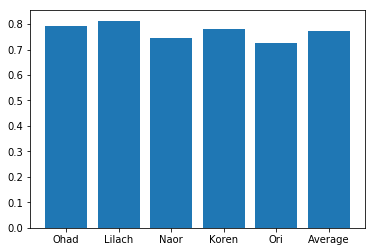

In [363]:
dictionary = plt.figure()

D = {u'Ohad':ohad_right_gbc/numOfMessagesPerSender,  u'Lilach':lilach_right_gbc/numOfMessagesPerSender , u'Naor':naor_right_gbc/numOfMessagesPerSender,
     u'Koren':koren_right_gbc/numOfMessagesPerSender, u'Ori':ori_right_gbc/numOfMessagesPerSender, u'Average':(ohad_right_gbc+lilach_right_gbc+naor_right_gbc+koren_right_gbc+ori_right_gbc) /(numOfMessagesPerSender*5)}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()


We can see that GBC algorithm recognize well most of the persons, aand the average produced graet results.

In [364]:
gbc_predict_messages = []

for i in range(0, numOfMessagesPerSender):
    gbc_predict_messages.extend(gbc.predict([all_ohad_messages_BOW[i]]))

for i in range(0, numOfMessagesPerSender):
    gbc_predict_messages.extend(gbc.predict([all_lilach_messages_BOW[i]]))

for i in range(0, numOfMessagesPerSender):
    gbc_predict_messages.extend(gbc.predict([all_naor_messages_BOW[i]]))
    
for i in range(0, numOfMessagesPerSender):
    gbc_predict_messages.extend(gbc.predict([all_koren_messages_BOW[i]]))
    
for i in range(0, numOfMessagesPerSender):
    gbc_predict_messages.extend(gbc.predict([all_ori_messages_BOW[i]]))


In [365]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[117  10  14   7   2]
 [  8 122   0  10  10]
 [  7   5 112  22   4]
 [  2  13   2 119  14]
 [  5  17   1  18 109]]


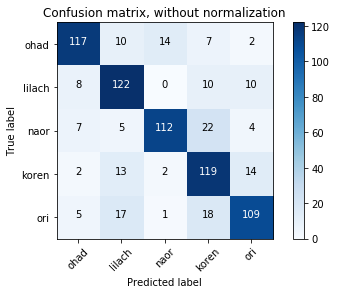

In [366]:

class_names = [ohadName , lilachName , naorName , korenName , oriName ]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(actual_senders, gbc_predict_messages)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

###Linear discriminant analysis Result
we report the accuracy of the Linear discriminant analysis alogrithm on every person.
By using the model we trained in part 2 and the messages we create in part 3.

In [367]:
ohad_right_lda = 0
lilach_right_lda = 0
naor_right_lda = 0
koren_right_lda = 0
ori_right_lda = 0

for i in range(0, numOfMessagesPerSender):
    if lda.predict([all_ohad_messages_BOW[i]]) == ohadName :
        ohad_right_lda = ohad_right_lda + 1
    if lda.predict([all_lilach_messages_BOW[i]]) == lilachName :
        lilach_right_lda = lilach_right_lda + 1
    if lda.predict([all_naor_messages_BOW[i]]) == naorName :
        naor_right_lda = naor_right_lda + 1
    if lda.predict([all_koren_messages_BOW[i]]) == korenName :
        koren_right_lda = koren_right_lda + 1
    if lda.predict([all_ori_messages_BOW[i]]) == oriName :
        ori_right_lda = ori_right_lda + 1
        
print ("Ohad success in LDA algorithm: " + str((ohad_right_lda/numOfMessagesPerSender)*100))
print ("Lilach success in LDA algorithm: " + str((lilach_right_lda/numOfMessagesPerSender)*100))
print ("Naor success in LDA algorithm: " + str((naor_right_lda/numOfMessagesPerSender)*100))
print ("Koren success in LDA algorithm: " + str((koren_right_lda/numOfMessagesPerSender)*100))
print ("Ori success in LDA algorithm: " + str((ori_right_lda/numOfMessagesPerSender)*100))
print()
print ("Success average in LDA algorithm: " + str(((ohad_right_lda+lilach_right_lda+naor_right_lda
                                   +koren_right_lda+ori_right_lda) /(numOfMessagesPerSender*5))*100))

Ohad success in LDA algorithm: 75.33333333333333
Lilach success in LDA algorithm: 70.0
Naor success in LDA algorithm: 87.33333333333333
Koren success in LDA algorithm: 68.66666666666667
Ori success in LDA algorithm: 68.66666666666667

Success average in LDA algorithm: 74.0


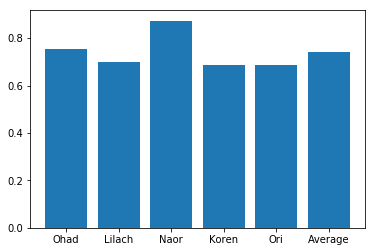

In [368]:
dictionary = plt.figure()

D = {u'Ohad':ohad_right_lda/numOfMessagesPerSender,  u'Lilach':lilach_right_lda/numOfMessagesPerSender , u'Naor':naor_right_lda/numOfMessagesPerSender,
     u'Koren':koren_right_lda/numOfMessagesPerSender, u'Ori':ori_right_lda/numOfMessagesPerSender, u'Average':(ohad_right_lda+lilach_right_lda+naor_right_lda+koren_right_lda+ori_right_lda) /(numOfMessagesPerSender*5)}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()

We can see that LDA algorithm not recognize so good the persons except one, LDA get lower results then the GBC algorithm


In [369]:
lda_predict_messages = []

for i in range(0, numOfMessagesPerSender):
    lda_predict_messages.extend(lda.predict([all_ohad_messages_BOW[i]]))

for i in range(0, numOfMessagesPerSender):
    lda_predict_messages.extend(lda.predict([all_lilach_messages_BOW[i]]))

for i in range(0, numOfMessagesPerSender):
    lda_predict_messages.extend(lda.predict([all_naor_messages_BOW[i]]))
    
for i in range(0, numOfMessagesPerSender):
    lda_predict_messages.extend(lda.predict([all_koren_messages_BOW[i]]))
    
for i in range(0, numOfMessagesPerSender):
    lda_predict_messages.extend(lda.predict([all_ori_messages_BOW[i]]))

Confusion matrix, without normalization
[[103  14  20   9   4]
 [ 13 105   2   7  23]
 [  9   9 131   0   1]
 [ 18   5  13 113   1]
 [  9   7  15  16 103]]


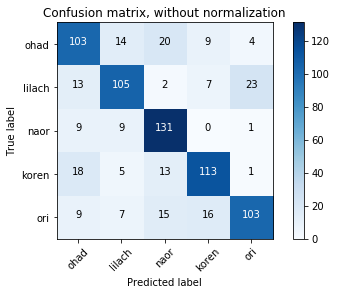

In [370]:
cnf_matrix = confusion_matrix(actual_senders, lda_predict_messages)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Lets compare between the success of the algorithm per person, and for the average sucess
First, define function for the calculation per person

In [371]:
def calculateMaxSuccessAlgorithm(maxSuccess, gcbAlgo, ldaAlgo):
    if(maxSuccess == gcbAlgo):
        return "Gradient boosting"
    elif(maxSuccess == ldaAlgo):
        return  "Linear discriminant analysis"

In [372]:
ohad_max_success = max(ohad_right_gbc/numOfMessagesPerSender, ohad_right_lda/numOfMessagesPerSender)
lilach_max_success = max(lilach_right_gbc/numOfMessagesPerSender, lilach_right_lda/numOfMessagesPerSender)
naor_max_success = max(naor_right_gbc/numOfMessagesPerSender, naor_right_lda/numOfMessagesPerSender)
koren_max_success = max(koren_right_gbc/numOfMessagesPerSender, koren_right_lda/numOfMessagesPerSender)
ori_max_success = max(ori_right_gbc/numOfMessagesPerSender, ori_right_lda/numOfMessagesPerSender)
average_max_success = max((ohad_right_gbc+lilach_right_gbc+naor_right_gbc +
                                   koren_right_gbc+ori_right_gbc) /(numOfMessagesPerSender*5),
                          (ohad_right_lda+lilach_right_lda+naor_right_lda +
                                   koren_right_lda+ori_right_lda) /(numOfMessagesPerSender*5))

ohad_algo = calculateMaxSuccessAlgorithm(ohad_max_success, ohad_right_gbc/numOfMessagesPerSender, ohad_right_lda/numOfMessagesPerSender)
lilach_algo = calculateMaxSuccessAlgorithm(lilach_max_success, lilach_right_gbc/numOfMessagesPerSender, lilach_right_lda/numOfMessagesPerSender)
naor_algo = calculateMaxSuccessAlgorithm(naor_max_success, naor_right_gbc/numOfMessagesPerSender, naor_right_lda/numOfMessagesPerSender)
koren_algo = calculateMaxSuccessAlgorithm(koren_max_success, koren_right_gbc/numOfMessagesPerSender, koren_right_lda/numOfMessagesPerSender)
ori_algo = calculateMaxSuccessAlgorithm(ori_max_success, ori_right_gbc/numOfMessagesPerSender, ori_right_lda/numOfMessagesPerSender)
average_algo = calculateMaxSuccessAlgorithm(average_max_success, (ohad_right_gbc+lilach_right_gbc+naor_right_gbc +
                                   koren_right_gbc+ori_right_gbc) /(numOfMessagesPerSender*5),
                          (ohad_right_lda+lilach_right_lda+naor_right_lda +
                                   koren_right_lda+ori_right_lda) /(numOfMessagesPerSender*5))

columns_list = ["Algorithm"]
rows_list = ["Ohad", "Lilach", "Naor", "Koren", "Ori", "Average"]

data = np.array([[ohad_algo], [lilach_algo], [naor_algo], [koren_algo], [ori_algo], [average_algo]])
pd.DataFrame(data, rows_list, columns_list)


,Algorithm
Ohad,Gradient boosting
Lilach,Gradient boosting
Naor,Linear discriminant analysis
Koren,Gradient boosting
Ori,Gradient boosting
Average,Gradient boosting


As we can see, the Gradient boosting algorithm has the best results among the persons.

##Conclusion
The results that we got in the process very highly and specific, but in the current version we predicts the next word in the sentence in random way with the highly frequency to the best word, but if we will learn the connections between words, then we can predict in more learned manner better words and get better results.